# Synthetic Community Graph Data Generation - Stochastic Block Model

This notebook generates synthetic data on a community graph (Stochastic Block Model) for testing graph-based interpolation methods.

**Key Features:**
- Stochastic Block Model with multiple communities
- Community-dependent synthetic function values
- Sparse random graph structure with community clustering
- Consistent node indexing for graph-based methods
- Random sparse sampling for training data
- Same data structure as wind interpolation example

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import time

# Configuration
N_NODES = 10000         # Total number of nodes (10K for faster computation)
N_COMMUNITIES = 4       # Number of communities
P_WITHIN = 0.01         # Probability of edge within community
P_BETWEEN = 0.001       # Probability of edge between communities
TRAINING_RATIO = 0.01   # 1% of nodes for training
NOISE_STD = 0.1         # Standard deviation of noise
RANDOM_SEED = 42        # For reproducibility

np.random.seed(RANDOM_SEED)

print(f"Configuration:")
print(f"  Total nodes: {N_NODES:,}")
print(f"  Communities: {N_COMMUNITIES}")
print(f"  P(within): {P_WITHIN}")
print(f"  P(between): {P_BETWEEN}")
print(f"  Training ratio: {TRAINING_RATIO*100:.1f}%")
print(f"  Expected training points: {int(N_NODES * TRAINING_RATIO):,}")
print(f"  Noise std: {NOISE_STD}")
print(f"  Random seed: {RANDOM_SEED}")

Configuration:
  Total nodes: 10,000
  Communities: 4
  P(within): 0.01
  P(between): 0.001
  Training ratio: 1.0%
  Expected training points: 100
  Noise std: 0.1
  Random seed: 42


In [2]:
# =============================================================================
# STOCHASTIC BLOCK MODEL GRAPH CONSTRUCTION
# =============================================================================

def build_stochastic_block_model(n_nodes, n_communities, p_within, p_between):
    """
    Build a stochastic block model graph
    
    Parameters:
    -----------
    n_nodes : int
        Total number of nodes
    n_communities : int
        Number of communities
    p_within : float
        Probability of edge within community
    p_between : float
        Probability of edge between communities
        
    Returns:
    --------
    A : scipy.sparse.csr_matrix
        Adjacency matrix
    communities : np.ndarray
        Community assignment for each node
    community_sizes : list
        Size of each community
    """
    # Assign nodes to communities (roughly equal sizes)
    community_sizes = [n_nodes // n_communities] * n_communities
    # Distribute remaining nodes
    for i in range(n_nodes % n_communities):
        community_sizes[i] += 1
    
    # Create community assignments
    communities = np.zeros(n_nodes, dtype=int)
    node_idx = 0
    for comm_id, size in enumerate(community_sizes):
        communities[node_idx:node_idx + size] = comm_id
        node_idx += size
    
    # Shuffle to avoid ordered community assignment
    np.random.shuffle(communities)
    
    # Build adjacency matrix
    rows, cols, data = [], [], []
    
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):  # Upper triangle only (undirected)
            # Determine if edge should exist
            if communities[i] == communities[j]:
                # Same community
                if np.random.random() < p_within:
                    rows.extend([i, j])
                    cols.extend([j, i])
                    data.extend([1.0, 1.0])
            else:
                # Different communities
                if np.random.random() < p_between:
                    rows.extend([i, j])
                    cols.extend([j, i])
                    data.extend([1.0, 1.0])
    
    A = sparse.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))
    return A.tocsr(), communities, community_sizes

print("Stochastic block model utilities defined")

Stochastic block model utilities defined


In [3]:
# =============================================================================
# COMMUNITY-DEPENDENT SYNTHETIC DATA GENERATION
# =============================================================================

def generate_community_function(n_nodes, communities, n_communities, noise_std=0.1):
    """
    Generate synthetic function values that depend on community structure
    
    Parameters:
    -----------
    n_nodes : int
        Total number of nodes
    communities : np.ndarray
        Community assignment for each node
    n_communities : int
        Number of communities
    noise_std : float
        Standard deviation of additive noise
        
    Returns:
    --------
    y : np.ndarray
        Function values at nodes
    community_means : np.ndarray
        Base function value for each community
    """
    # Generate base function values for each community
    # Communities have different base levels with some overlap
    community_means = np.random.uniform(-2.0, 2.0, n_communities)
    
    # Add smooth transitions between communities using a sinusoidal pattern
    base_values = np.zeros(n_nodes)
    
    for node in range(n_nodes):
        comm_id = communities[node]
        
        # Base value from community
        base_val = community_means[comm_id]
        
        # Add smooth variation within community (based on node position)
        # Use node index to create spatial-like structure
        phase = 2 * np.pi * (node % 1000) / 1000.0  # Create periodicity
        variation = 0.5 * np.sin(phase + comm_id * np.pi/2)  # Different phase per community
        
        base_values[node] = base_val + variation
    
    # Add noise
    noise = np.random.normal(0, noise_std, n_nodes)
    y_values = base_values + noise
    
    return y_values, community_means

print("Community-dependent data generation function defined")

Community-dependent data generation function defined


Building community graph and generating synthetic data...
Graph construction completed in 27.50 seconds
  Adjacency matrix shape: (10000, 10000)
  Number of edges: 324,930
  Community sizes: [2500, 2500, 2500, 2500]
Graph construction completed in 27.50 seconds
  Adjacency matrix shape: (10000, 10000)
  Number of edges: 324,930
  Community sizes: [2500, 2500, 2500, 2500]

✅ Community graph dataset saved to 'synthetic_community_10k.npz'
✅ Nodes: 10,000, Communities: 4, Training: 100

✅ Community graph dataset saved to 'synthetic_community_10k.npz'
✅ Nodes: 10,000, Communities: 4, Training: 100


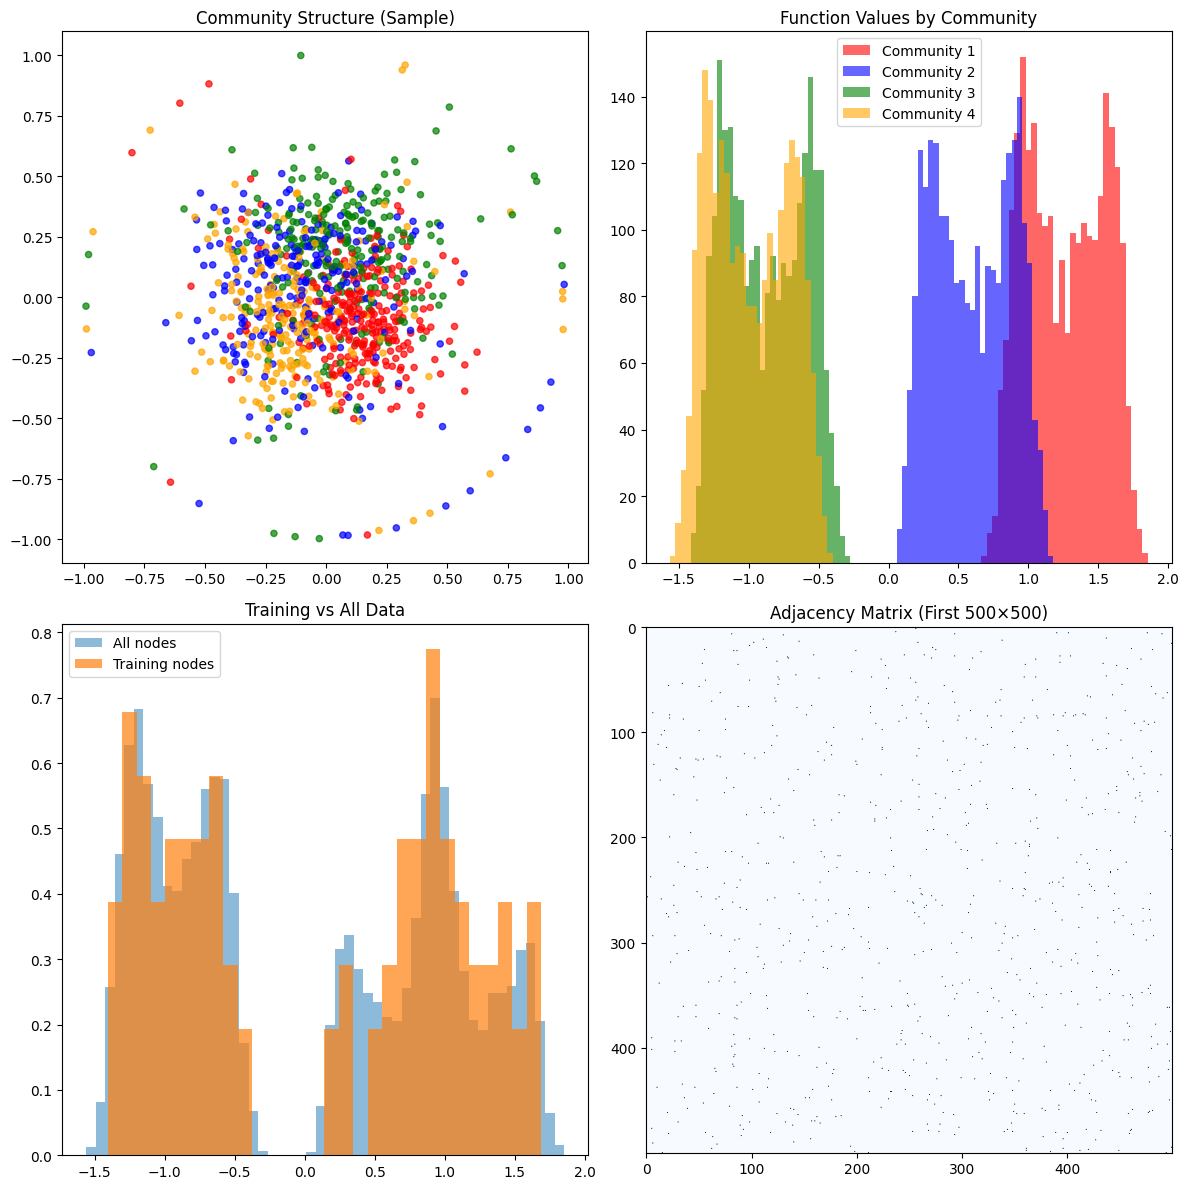


Community information:
  Community 1: 2,500 nodes, mean value: 1.094
  Community 2: 2,500 nodes, mean value: 0.221
  Community 3: 2,500 nodes, mean value: -1.705
  Community 4: 2,500 nodes, mean value: -1.853

Graph statistics:
  Average degree: 32.49
  Density: 0.003250


In [4]:
# =============================================================================
# BUILD COMMUNITY GRAPH AND GENERATE DATA
# =============================================================================

print("Building community graph and generating synthetic data...")
start_time = time.time()

# Build stochastic block model
A, communities, community_sizes = build_stochastic_block_model(N_NODES, N_COMMUNITIES, P_WITHIN, P_BETWEEN)
print(f"Graph construction completed in {time.time() - start_time:.2f} seconds")
print(f"  Adjacency matrix shape: {A.shape}")
print(f"  Number of edges: {A.nnz:,}")
print(f"  Community sizes: {community_sizes}")

# Generate community-dependent synthetic data
y, community_means = generate_community_function(N_NODES, communities, N_COMMUNITIES, NOISE_STD)

# Normalize data
y_mean, y_std = np.mean(y), np.std(y)
y_normalized = (y - y_mean) / y_std

# Generate training data
X = np.arange(N_NODES)
n_training = int(N_NODES * TRAINING_RATIO)
X_train = np.sort(np.random.choice(N_NODES, size=n_training, replace=False))
y_train = y_normalized[X_train]

# Create coordinate mapping (use community layout for visualization)
coord_mapping = np.zeros((N_NODES, 2))
for i, comm_id in enumerate(communities):
    # Arrange communities in a 2x2 grid pattern
    comm_x = (comm_id % 2) * 2 - 1  # -1 or 1
    comm_y = (comm_id // 2) * 2 - 1  # -1 or 1
    
    # Add random offset within community
    offset_x = np.random.uniform(-0.4, 0.4)
    offset_y = np.random.uniform(-0.4, 0.4)
    
    coord_mapping[i] = [comm_x + offset_x, comm_y + offset_y]

# Save dataset
np.savez('synthetic_community_10k.npz',
         A_data=A.data, A_indices=A.indices, A_indptr=A.indptr, A_shape=A.shape,
         X=X, y=y_normalized, y_mean=y_mean, y_std=y_std,
         X_train=X_train, y_train=y_train, coord_mapping=coord_mapping,
         communities=communities, community_means=community_means,
         n_nodes=N_NODES, n_communities=N_COMMUNITIES,
         p_within=P_WITHIN, p_between=P_BETWEEN,
         noise_std=NOISE_STD, training_ratio=TRAINING_RATIO, random_seed=RANDOM_SEED)

print(f"\n✅ Community graph dataset saved to 'synthetic_community_10k.npz'")
print(f"✅ Nodes: {N_NODES:,}, Communities: {N_COMMUNITIES}, Training: {len(X_train):,}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Community structure
colors = ['red', 'blue', 'green', 'orange'][:N_COMMUNITIES]
node_colors = [colors[communities[i]] for i in range(N_NODES)]

# Use NetworkX for graph layout (sample for visualization)
sample_size = min(1000, N_NODES)  # Sample for faster visualization
sample_nodes = np.random.choice(N_NODES, sample_size, replace=False)
G_sample = nx.Graph()
G_sample.add_nodes_from(sample_nodes)

# Add sample edges
A_sample = A[sample_nodes][:, sample_nodes]
rows, cols = A_sample.nonzero()
edges = [(sample_nodes[i], sample_nodes[j]) for i, j in zip(rows, cols) if i < j]
G_sample.add_edges_from(edges)

pos = nx.spring_layout(G_sample, k=0.5, iterations=50)
sample_colors = [colors[communities[node]] for node in sample_nodes]

axes[0,0].scatter([pos[node][0] for node in sample_nodes], 
                  [pos[node][1] for node in sample_nodes], 
                  c=sample_colors, s=20, alpha=0.7)
axes[0,0].set_title('Community Structure (Sample)')

# Function values by community
for comm_id in range(N_COMMUNITIES):
    comm_nodes = np.where(communities == comm_id)[0]
    comm_values = y_normalized[comm_nodes]
    axes[0,1].hist(comm_values, bins=30, alpha=0.6, label=f'Community {comm_id+1}', color=colors[comm_id])
axes[0,1].set_title('Function Values by Community')
axes[0,1].legend()

# Training data distribution
axes[1,0].hist(y_normalized, bins=50, alpha=0.5, label='All nodes', density=True)
axes[1,0].hist(y_train, bins=30, alpha=0.7, label='Training nodes', density=True)
axes[1,0].set_title('Training vs All Data')
axes[1,0].legend()

# Adjacency matrix structure (small sample)
sample_adj = A[:500, :500].toarray()
axes[1,1].imshow(sample_adj, cmap='Blues', aspect='equal')
axes[1,1].set_title('Adjacency Matrix (First 500×500)')

plt.tight_layout()
plt.show()

print(f"\nCommunity information:")
for i in range(N_COMMUNITIES):
    comm_nodes = np.sum(communities == i)
    print(f"  Community {i+1}: {comm_nodes:,} nodes, mean value: {community_means[i]:.3f}")
    
print(f"\nGraph statistics:")
print(f"  Average degree: {A.nnz / N_NODES:.2f}")
print(f"  Density: {A.nnz / (N_NODES * (N_NODES - 1)):.6f}")